In [1]:
import scanpy as sc
import os
import matplotlib.pyplot as plt
import bin2cell as b2c
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Basic preprocessing of the 2 um bins data

In [2]:
name = "D1_Johnson"

In [3]:
adata = sc.read_h5ad(f"./{name}/{name}_raw_002um.h5ad")

In [4]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

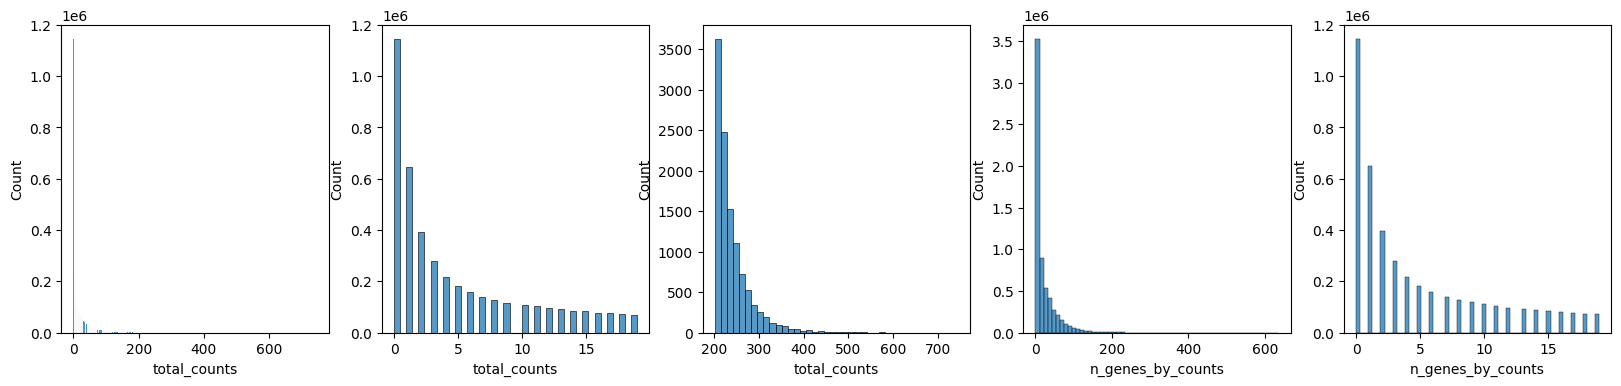

In [5]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] <20],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] >200],
    kde=False,
    bins=40,
    ax=axs[2],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[3])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 20],
    kde=False,
    bins=60,
    ax=axs[4],
)

In [8]:
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.filter_cells(adata, max_counts=400)
sc.pp.filter_genes(adata, min_cells=5)

In [9]:
adata

AnnData object with n_obs × n_vars = 3684886 × 17861
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
adata.write(f"./{name}/{name}_processed_002um.h5ad")

## Run Thor to get cell-level spatial transcriptomics data

In [2]:
import sys
import os
import logging
import datetime

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s')

now = datetime.datetime.now()
logger.info(f"Current Time: {now}")

root - INFO - Current Time: 2024-12-04 14:40:41.516870


In [3]:
%config InlineBackend.figure_format = 'retina'


import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300)
sc.settings.verbosity = 'error'


from thor.pp import WholeSlideImage, Spatial
from thor.finest import fineST

2024-12-04 14:41:12.157997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 14:41:12.158173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 14:41:12.313340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import logging
import pandas as pd

from anndata import AnnData

logger = logging.getLogger(__name__)

def spot2cell(cell_locs, spot_locs, cell_radius):
    """
    Aggregate the spots to the cells based on the distance between the spots and the cells.

    Parameters:
    - cell_locs: numpy array of shape (n_cells, 2) with the x, y coordinates of the cells.
    - spot_locs: numpy array of shape (n_spots, 2) with the x, y coordinates of the spots.
    - cell_radius: float, the radius of the cells.

    Returns:
    - assignments: A csr_matrix of shape (n_cells, n_spots) with the assignments of the spots to the cells.
    """
    import numpy as np
    from sklearn.neighbors import NearestNeighbors

    # Initialize the NearestNeighbors model with the specified radius
    neigh = NearestNeighbors(radius=cell_radius)

    # Fit the model on the spot locations
    neigh.fit(spot_locs)

    # Create the radius neighbors graph
    A = neigh.radius_neighbors_graph(cell_locs, mode='connectivity')

    # Exclude empty rows
    non_empty_rows = np.diff(A.indptr) != 0
    A = A[non_empty_rows]

    return A, non_empty_rows


def aggregate_features(spot_features, cellxspot, method='mean'):
    """
    Aggregate the spot features to the cells based on the assignments.

    Parameters:
    - spot_features: csr_matrix of shape (n_spots, n_features) with the features of the spots.
    - assignments: list of lists, the list of spots assigned to each cell.

    Returns:
    - cell_features: csr_matrix of shape (n_cells, n_features) with the aggregated features of the cells.
    """

    print("The shape of the transformed cellxspot is: ", cellxspot.shape)
    assert method in ['mean', 'sum']

    # When you transpose a csr_matrix, it becomes a dense array...
    if method == 'mean':
        cellxspot = row_normalize_sparse(cellxspot)

    cell_features = cellxspot @ spot_features

    return cell_features


def HD2cell(adata_spot, node_feat, margin=1, cell_radius=10):
    """ Assigning ST of segmented cells by the nearest spots (1 or 0 for each cell). If the nearest spot is within the margin, the cell is assigned to the spot.
    
    Parameters
    ----------
    adata_spot: AnnData
        The AnnData object containing the spot data.
    node_feat: pd.DataFrame
        The dataframe containing the cell features.
    margin: float
        The scale for assigning the spots to the cells. 1 means the spot is within the cell radius.
    cell_radius: float
        The radius of the cells in microns.

    Returns
    -------
    adata_cell: AnnData
        The AnnData object containing the cell data.
    assignments: list
        The list of spot indices that are mapped to cells.
    """

    spot_pos = pd.DataFrame(
        adata_spot.obsm['spatial'],
        columns=['x', 'y'],
        index=adata_spot.obs.index
    )

    scalf = get_scalefactors(adata_spot)
    microns_per_pixel = scalf['microns_per_pixel']

    cell_r = cell_radius / microns_per_pixel

    cell_pos = node_feat[['x', 'y']]

    # Assign spots to cells
    assignments, non_empty_rows = spot2cell(cell_pos.values, spot_pos.values, cell_r * margin)

    # Aggregate the features
    cell_features = aggregate_features(adata_spot.X, assignments, method='mean')
    node_feat = node_feat[non_empty_rows]

    # Create the cell AnnData object
    adata_cell = AnnData(
        X=cell_features, obs=node_feat, var=adata_spot.var, uns=adata_spot.uns
    )

    adata_cell.obsm['spatial'] = node_feat.iloc[:, :2].values

    return adata_cell, assignments


def get_library_id(adata):
    assert 'spatial' in adata.uns, "spatial not present in adata.uns"
    library_ids = adata.uns['spatial'].keys()
    try:
        library_id = list(library_ids)[0]
        return library_id
    except IndexError:
        logger.error('No library_id found in adata')


def get_scalefactors(adata, library_id=None):
    if library_id is None:
        library_id = get_library_id(adata)
    try:
        scalef = adata.uns['spatial'][library_id]['scalefactors']
        return scalef
    except IndexError:
        logger.error('scalefactors not found in adata')


def row_normalize_sparse(csr):
    """
    Each row sums to 1
    """
    from sklearn.preprocessing import normalize

    csr_normalized = normalize(csr, norm='l1', axis=1)
    return csr_normalized

In [ ]:
# name = "D1_Johnson"
# image_path = f"./{name}_Scan1.qptiff.tiff"

# wsi = WholeSlideImage(image_path, name=name)
# wsi.process(method="stardist")

# cell_mask_path = os.path.join(image_process_dir, "nuclei_mask.npz")
# wsi = WholeSlideImage(image_path, name=name, nuclei_seg_path=cell_mask_path, nuclei_seg_format='mask_array_npz')
# wsi.process()

In [12]:
outdir = os.getcwd()
image_path = f"./{name}_Scan1.qptiff.tiff"
image_process_dir = os.path.join(outdir, f'WSI_{name}')
cell_mask_path = os.path.join(image_process_dir, "nuclei_mask.npz")
cell_feature_path = os.path.join(image_process_dir, "cell_features.csv")
spatial_dir = f"./{name}"
spot_adata_path = os.path.join(spatial_dir, f"{name}_processed_002um.h5ad")


In [14]:
cell_feature = pd.read_csv(cell_feature_path,index_col=0)
spot = sc.read_h5ad(spot_adata_path)

In [ ]:
adata_cell, assignments = HD2cell(adata_spot=spot, node_feat=cell_feature)

In [ ]:
sample = fineST(
    image_path,
    name=name,
    spot_adata_path=spot_adata_path,
    cell_features_csv_path=cell_feature_path
)
sample.prepare_input(mapping_margin=10)

In [ ]:
sc.pp.normalize_total(adata_cell,target_sum=10000)
sc.pp.log1p(adata_cell)

In [ ]:
sample.adata.X = adata_cell.X
sample.adata.obs_names = adata_cell.obs_names

In [ ]:
sample.genes = [
    "VIM",  # Vimentin
    "ACTA2",  # Alpha Smooth Muscle Actin (αSMA)
    "CAV1",  # Caveolin 1
    "CAV2",  # Caveolin 2
    "PDGFRA",  # Platelet Derived Growth Factor Receptor Alpha
    "CD34",  # CD34 Molecule
    "GJA1",  # Gap Junction Protein Alpha 1 (Connexin 43)
    "KIT",  # KIT Proto-Oncogene, Receptor Tyrosine Kinase
    "CDH11",  # Cadherin 11
    "PDGFRB",  # Platelet Derived Growth Factor Receptor Beta
    "CSPG4",  # Chondroitin Sulfate Proteoglycan 4 (NG2)
    "PECAM1",  # Platelet And Endothelial Cell Adhesion Molecule 1 (CD31)
    "FAP",  # Fibroblast Activation Protein Alpha
    "TNC",  # Tenascin C
    "THY1",  # Thy-1 Cell Surface Antigen (CD90)
    "S100A4",  # S100 Calcium Binding Protein A4 (FSP1)
    "DLL4"  # Delta Like Canonical Notch Ligand 4
]

In [ ]:
sample.set_genes_for_prediction(genes_selection_key=None)

In [ ]:
sample.recipe = 'gene'
sample.set_params(
    is_rawCount=False,
    out_prefix="fineST",
    write_freq=20,
    n_iter=20,
    conn_csr_matrix="force",
    smoothing_scale=0.8,
    node_features_obs_list=['spot_heterogeneity'],
    n_neighbors=10,
    geom_morph_ratio=0.5,
    geom_constraint=0,
    inflation_percentage=None,
    regulate_expression_mean=False,
    stochastic_expression_neighbors_level='spot',
    smooth_predicted_expression_steps=0,
    reduced_dimension_transcriptome_obsm_key=None,
    adjust_cell_network_by_transcriptome_scale=0,
    n_jobs=20)

In [ ]:
sample.predict_gene_expression()

In [ ]:
ad_thor = sample.load_result('fineST_20.npz')

In [ ]:
ad_thor.write(f"./{name}/{name}_thor_result_002um.h5ad")